In [2]:
import pandas as pd
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
import tensorflow as tf


In [3]:
data = pd.read_csv('/kaggle/input/indooo/indo.csv')
data['Text'] = data['Text'].astype(str)
texts = data['Text'].values
labels = data['Sentiment'].values

In [4]:
# %pip install Sastrawi
# import nltk
# nltk.download('wordnet')
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re

stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

lemmatizer = WordNetLemmatizer()

for index, text in enumerate(texts):
    text = text.lower()

    text = re.sub(pattern, '', text)

    word_list = word_tokenize(text)
    word_list = [word for word in word_list if word not in stopwords]
    
    word_list = [lemmatizer.lemmatize(word) for word in word_list]

    text = ' '.join(word_list)
    texts[index] = text

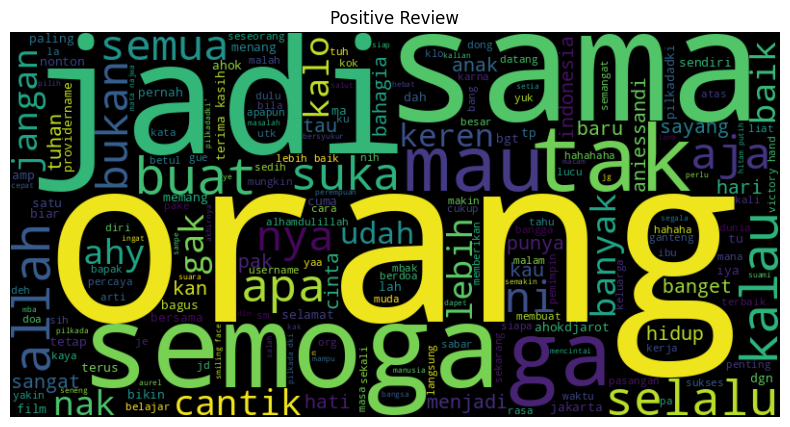

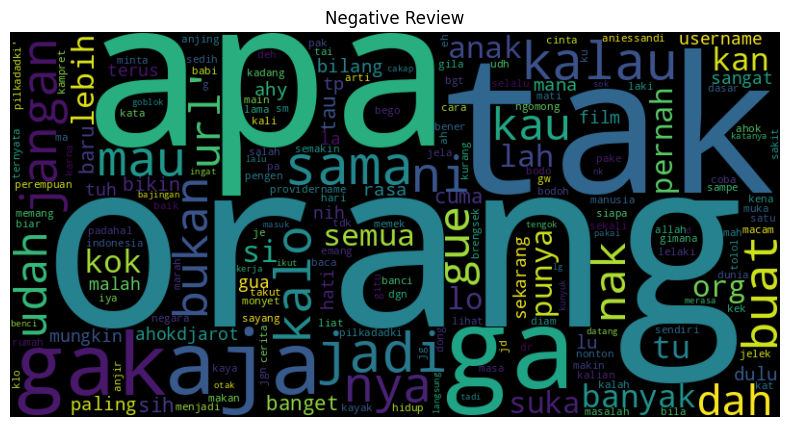

In [5]:
def generate_wordcloud(text,Title):
    all_text = "".join(str(text))
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()
    
positive = texts[labels=='positive'].tolist()
generate_wordcloud(positive,'Positive Review')

negative = texts[labels=='negative'].tolist()
generate_wordcloud(negative,'Negative Review')

In [6]:
train_texts, tests_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

In [7]:
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts,padding=True,truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(tests_texts.tolist())


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
test_labels = le.fit_transform(test_labels)

In [9]:
import torch
from transformers import TFBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = TFBertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=2, from_pt=True)


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110558208 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110559746 (421.75 MB)
Trainable params: 110559746 (421.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.rate = 0.2


In [12]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        print(f"Layer: {layer.name}, Dropout rate: {layer.rate}")

Layer: dropout_37, Dropout rate: 0.2


In [13]:
epochs = 3
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [14]:
history = model.fit(
    [train_encodings['input_ids'], train_encodings['token_type_ids'], train_encodings['attention_mask']],
    train_labels, validation_split = 0.1,
    batch_size=16,
    epochs=epochs
)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1717798563.620825    9895 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


414/414 [==============================] - 263s 411ms/step - loss: 0.4644 - accuracy: 0.7779 - val_loss: 0.3782 - val_accuracy: 0.8476
Epoch 2/3
414/414 [==============================] - 156s 376ms/step - loss: 0.2815 - accuracy: 0.8880 - val_loss: 0.3927 - val_accuracy: 0.8422
Epoch 3/3
414/414 [==============================] - 155s 375ms/step - loss: 0.1765 - accuracy: 0.9343 - val_loss: 0.4240 - val_accuracy: 0.8395


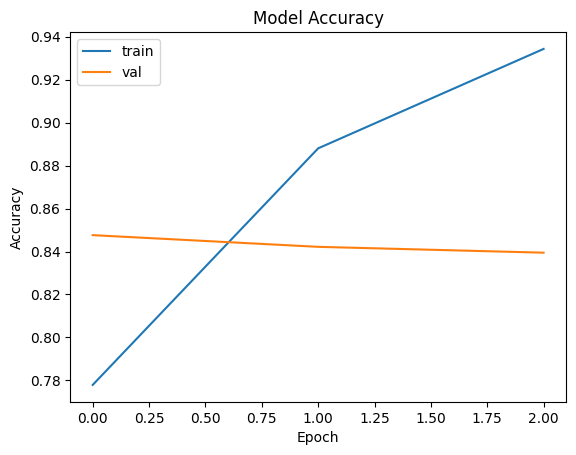

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
pred = model.predict([test_encodings['input_ids'], test_encodings['token_type_ids'], test_encodings['attention_mask']])
pred_labels = tf.argmax(pred.logits, axis=1)
from sklearn.metrics import accuracy_score
print(accuracy_score(pred_labels, test_labels))


58/58 [==============================] - 19s 131ms/step
0.8572984749455338


In [17]:
model.save_pretrained('sentiment_model')
tokenizer.save_pretrained('sentiment_model')

('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/vocab.txt',
 'sentiment_model/added_tokens.json')

In [18]:
model = TFBertForSequenceClassification.from_pretrained('sentiment_model')
tokenizer = BertTokenizer.from_pretrained('sentiment_model')


Some layers from the model checkpoint at sentiment_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at sentiment_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [19]:
labels = ['negative', 'positive']
def predict_sentiment(text):
    encoding = tokenize_function(text)
    pred = model.predict([encoding['input_ids'], encoding['token_type_ids'], encoding['attention_mask']])
    pred_labels = tf.argmax(pred.logits, axis=1)
 
    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [labels[i] for i in pred_labels.numpy().tolist()]
    print(pred_labels)

predict_sentiment("huhiapa yang setan aku tak tahu apapun alasannya aku tak ingin tahu perasaan pembunuh kogoro mouri")


1/1 [==============================] - 14s 14s/step
['negative']


In [20]:
pilkada = pd.read_csv('/kaggle/input/pilkada/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
x = tokenize_function(pilkada['Text Tweet'].tolist())
y = pilkada['Sentiment']
y = le.fit_transform(y)
pred = model.predict([x['input_ids'], x['token_type_ids'], x['attention_mask']])
pred_labels = tf.argmax(pred.logits, axis=1)
pred_labels
from sklearn.metrics import accuracy_score
print(accuracy_score(pred_labels, y))

29/29 [==============================] - 14s 140ms/step
0.8733333333333333
